In [25]:
import os
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchattacks
from torchvision import models

In [26]:
class TinyImageNetValidationDataset(Dataset):
    def __init__(self, root_dir, annotations_file, wnids_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the validation images.
            annotations_file (string): Path to the val_annotations.txt file.
            wnids_file (string): Path to the wnids.txt file containing class synset IDs.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.annotations_file = annotations_file
        self.wnids_file = wnids_file
        self.transform = transform

        # Read the synset-to-class index mapping from wnids.txt
        self.synset_to_class = {}
        with open(self.wnids_file, 'r') as f:
            for idx, line in enumerate(f):
                synset_id = line.strip()
                self.synset_to_class[synset_id] = idx  # Map synset ID to class index

        # Read the val_annotations.txt file to get class labels for validation images
        self.image_class_map = {}
        with open(self.annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                image_filename = parts[0]
                synset_id = parts[1]
                class_index = self.synset_to_class.get(synset_id)  # Convert synset ID to class index
                self.image_class_map[image_filename] = class_index

        # Get the list of all image filenames in the 'images/' directory
        self.image_filenames = os.listdir(os.path.join(self.root_dir, 'images'))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get the image filename
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.root_dir, 'images', img_name)
        
        # Open the image
        image = Image.open(img_path).convert('RGB')

        # Get the label for the image from the image_class_map
        label = self.image_class_map[img_name]

        # Apply the transformation if any
        if self.transform:
            image = self.transform(image)

        return image, label

In [27]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to data files
val_dir = 'tiny-imagenet-200/val'
annotations_file = 'tiny-imagenet-200/val/val_annotations.txt'
wnids_file = 'tiny-imagenet-200/wnids.txt'

# Load the validation dataset
val_dataset = TinyImageNetValidationDataset(
    root_dir=val_dir,
    annotations_file=annotations_file,
    wnids_file=wnids_file,
    transform=transform
)

# Create a DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

# Check number of images in the dataset
print(f"Number of images in validation set: {len(val_loader.dataset)}")

Number of images in validation set: 10000


In [1]:
model = models.resnet50(pretrained=True)

# Modify the last fully connected layer to match Tiny ImageNet's 200 classes
model.fc = torch.nn.Linear(model.fc.in_features, 200)

# Set model to evaluation mode and move to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

NameError: name 'models' is not defined

In [89]:
attack = attack = torchattacks.PGD(model, eps=0.003, alpha=0.001, steps=10)

# Step 5: Generate Adversarial Examples
data_iter = iter(val_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Generate adversarial examples
adv_images = attack(images, labels)

In [90]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Forward hook to save activations
        target_layer.register_forward_hook(self.save_activations)
        # Backward hook to save gradients
        target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = torch.argmax(output, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Pool gradients
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # Weight the activations
        weighted_activations = torch.zeros_like(self.activations)
        for i in range(self.activations.shape[1]):
            weighted_activations[:, i, :, :] = self.activations[:, i, :, :] * pooled_gradients[i]
        
        # Generate heatmap
        heatmap = torch.mean(weighted_activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize
        
        return heatmap.cpu().numpy()

In [91]:
# Get the target layer (last conv layer in ResNet18)
target_layer = model.layer4[-1].conv2

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Get a batch of clean and adversarial images
clean_images, labels = next(iter(val_loader))
clean_images, labels = clean_images.to(device), labels.to(device)
adv_images = attack(clean_images, labels)  # Generate adversarial examples

# Get heatmaps
clean_heatmap = grad_cam(clean_images[0:1], labels[0])  # For first clean image
adv_heatmap = grad_cam(adv_images[0:1], labels[0])      # For corresponding adversarial image

def load_class_names(wnids_file, words_file='tiny-imagenet-200/words.txt'):
    # Load synset to class index mapping (from your existing code)
    synset_to_class = {}
    with open(wnids_file, 'r') as f:
        for idx, line in enumerate(f):
            synset_id = line.strip()
            synset_to_class[synset_id] = idx
    
    # Load synset to class name mapping
    synset_to_name = {}
    with open(words_file, 'r') as f:
        for line in f:
            synset_id, name = line.strip().split('\t', 1)
            synset_to_name[synset_id] = name.split(',')[0]  # Take the first name
    
    # Create class index to name mapping
    class_to_name = {v: synset_to_name[k] for k, v in synset_to_class.items()}
    return class_to_name

Model prediction: rocking chair (Class 3)
Model prediction: orangutan (Class 159)


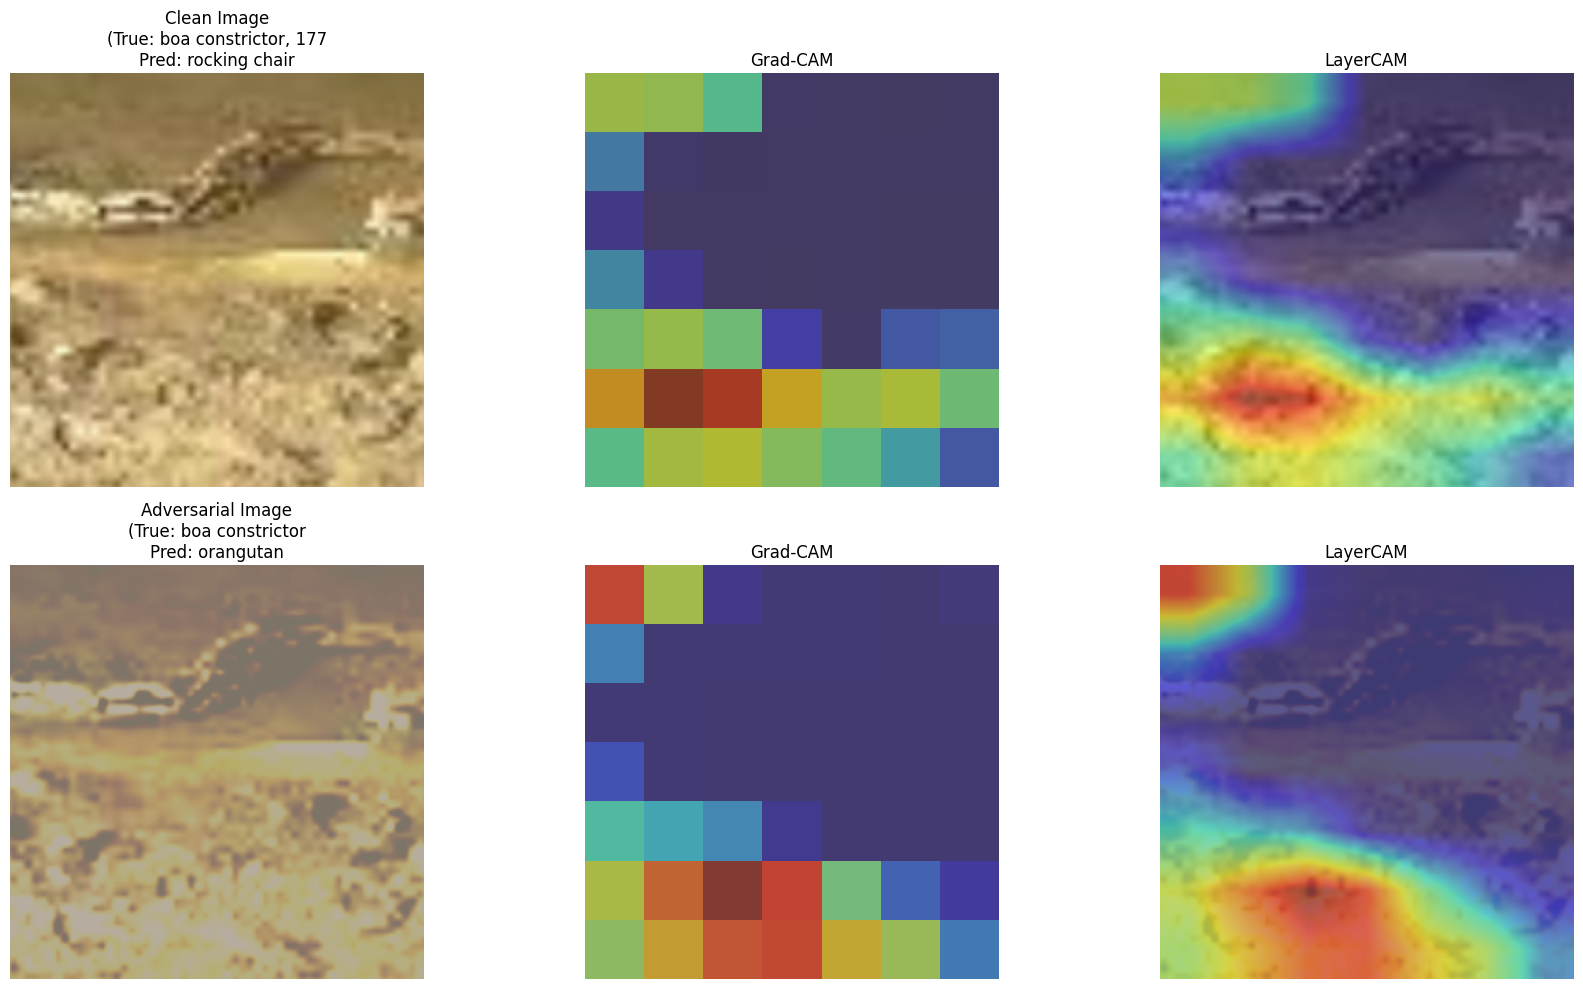

Grad-CAM Comparison:
 SSIM: 0.870, L1 Distance: 0.098
LayerCAM Comparison:
 SSIM: 0.754, L1 Distance: 0.085


In [92]:
# ======================
# LayerCAM Implementation with Class Names
# ======================
class LayerCAM:
    def __init__(self, model, target_layers, class_to_name=None):
        self.model = model
        self.target_layers = target_layers
        self.class_to_name = class_to_name
        self.gradients = {}
        self.activations = {}
        
        # Register hooks for each target layer
        for layer in target_layers:
            layer.register_forward_hook(self.save_activation)
            layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations[module] = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients[module] = grad_output[0].detach()
    
    def __call__(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)
        
        # Print predictions if class names are available
        if self.class_to_name is not None:
            pred_class = output.argmax().item()
            pred_name = self.class_to_name.get(pred_class, f"Class {pred_class}")
            print(f"Model prediction: {pred_name} (Class {pred_class})")
        
        if target_class is None:
            target_class = torch.argmax(output, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Process each target layer
        cam_per_layer = []
        for layer in self.target_layers:
            activations = self.activations[layer]
            gradients = self.gradients[layer]
            
            # Element-wise multiply gradients with activations
            weights = F.adaptive_avg_pool2d(gradients, 1)
            weighted_activations = activations * weights
            
            # Sum across channels and apply ReLU
            cam = torch.sum(weighted_activations, dim=1, keepdim=True)
            cam = F.relu(cam)
            
            # Normalize and resize to input size
            cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
            cam_per_layer.append(cam)
        
        # Average CAMs across all target layers
        final_cam = torch.mean(torch.stack(cam_per_layer), dim=0)
        return final_cam.squeeze().cpu().numpy()

# ======================
# Visualization Function with Prediction Names
# ======================
def plot_layer_comparison(clean_img, adv_img, clean_cam, adv_cam, 
                         label, clean_pred_name, adv_pred_name,
                         class_to_name=None):
    # Convert tensors to numpy arrays
    clean_img = clean_img.squeeze().permute(1, 2, 0).cpu().numpy()
    adv_img = adv_img.squeeze().permute(1, 2, 0).cpu().numpy()
    
    # Denormalize images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    clean_img = std * clean_img + mean
    adv_img = std * adv_img + mean
    clean_img = np.clip(clean_img, 0, 1)
    adv_img = np.clip(adv_img, 0, 1)
    
    # Get true class name if available
    true_class_name = class_to_name.get(label, f"Class {label}") if class_to_name else f"Class {label}"
    
    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Clean Image
    axes[0, 0].imshow(clean_img)
    axes[0, 0].set_title(f"Clean Image\n(True: {true_class_name}, {label}\nPred: {clean_pred_name}")
    axes[0, 0].axis('off')
    
    # Clean Grad-CAM
    axes[0, 1].imshow(clean_img)
    axes[0, 1].imshow(clean_heatmap, cmap='jet', alpha=0.5)
    axes[0, 1].set_title("Grad-CAM")
    axes[0, 1].axis('off')
    
    # Clean LayerCAM
    axes[0, 2].imshow(clean_img)
    axes[0, 2].imshow(clean_cam, cmap='jet', alpha=0.5)
    axes[0, 2].set_title("LayerCAM")
    axes[0, 2].axis('off')
    
    # Adversarial Image
    axes[1, 0].imshow(adv_img)
    axes[1, 0].set_title(f"Adversarial Image\n(True: {true_class_name}\nPred: {adv_pred_name}")
    axes[1, 0].axis('off')
    
    # Adversarial Grad-CAM
    axes[1, 1].imshow(adv_img)
    axes[1, 1].imshow(adv_heatmap, cmap='jet', alpha=0.5)
    axes[1, 1].set_title("Grad-CAM")
    axes[1, 1].axis('off')
    
    # Adversarial LayerCAM
    axes[1, 2].imshow(adv_img)
    axes[1, 2].imshow(adv_cam, cmap='jet', alpha=0.5)
    axes[1, 2].set_title("LayerCAM")
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# ======================
# Run LayerCAM Analysis with Class Names
# ======================
# First load class names (assuming you have this function from previous code)
class_to_name = load_class_names(wnids_file)

# Define target layers
target_layers = [model.layer3[-1].conv2, model.layer4[-1].conv2]
target_layers = [model.layer4[-1].conv2]


# Initialize LayerCAM with class names
layer_cam = LayerCAM(model, target_layers, class_to_name)

# Get predictions for clean and adversarial images
def get_prediction_name(model, image, class_to_name):
    with torch.no_grad():
        output = model(image)
        pred_class = output.argmax().item()
        return class_to_name.get(pred_class, f"Class {pred_class}")

clean_pred_name = get_prediction_name(model, clean_images[0:1], class_to_name)
adv_pred_name = get_prediction_name(model, adv_images[0:1], class_to_name)

# Get LayerCAM heatmaps
clean_layer_cam = layer_cam(clean_images[0:1], labels[0])
adv_layer_cam = layer_cam(adv_images[0:1], labels[0])

# Plot comparison with prediction names
plot_layer_comparison(
    clean_images[0],
    adv_images[0],
    clean_layer_cam,
    adv_layer_cam,
    labels[0].item(),
    clean_pred_name,
    adv_pred_name,
    class_to_name
)

# ======================
# Quantitative Comparison
# ======================
from skimage.metrics import structural_similarity as ssim

def compare_attention_maps(clean_map, adv_map):
    """Calculate similarity between clean and adversarial attention maps"""
    ssim_score = ssim(clean_map, adv_map, data_range=1.0)
    l1_dist = np.mean(np.abs(clean_map - adv_map))
    return ssim_score, l1_dist

# Compare Grad-CAM
gradcam_ssim, gradcam_l1 = compare_attention_maps(clean_heatmap, adv_heatmap)

# Compare LayerCAM
layercam_ssim, layercam_l1 = compare_attention_maps(clean_layer_cam, adv_layer_cam)

print(f"Grad-CAM Comparison:\n SSIM: {gradcam_ssim:.3f}, L1 Distance: {gradcam_l1:.3f}")
print(f"LayerCAM Comparison:\n SSIM: {layercam_ssim:.3f}, L1 Distance: {layercam_l1:.3f}")

In [93]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def test_model_accuracy(model, dataloader, class_to_name=None, device='cuda'):
    """
    Test model accuracy on clean images
    
    Args:
        model: Pretrained model
        dataloader: Validation/test dataloader
        class_to_name: Optional dictionary mapping class indices to names
        device: Device to run on ('cuda' or 'cpu')
    
    Returns:
        accuracy: Percentage of correctly classified images
        wrong_samples: List of (image_idx, predicted_class, true_class) for errors
    """
    model.eval()
    correct = 0
    total = 0
    wrong_samples = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader)):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Record wrong predictions
            wrong_mask = predicted != labels
            for i in range(len(predicted)):
                if wrong_mask[i]:
                    global_idx = batch_idx * dataloader.batch_size + i
                    wrong_samples.append((
                        global_idx,
                        predicted[i].item(),
                        labels[i].item()
                    ))
    
    accuracy = 100 * correct / total
    print(f"\nAccuracy on clean images: {accuracy:.2f}% ({correct}/{total})")
    
    if class_to_name:
        print("\nSample misclassifications:")
        for idx, pred, true in wrong_samples[:5]:  # Print first 5 errors
            print(f"Image {idx}: Predicted {class_to_name.get(pred, pred)} (Class {pred})")
            print(f"          True {class_to_name.get(true, true)} (Class {true})\n")
    
    return accuracy, wrong_samples

# ===========================================
# Run the Evaluation
# ===========================================
if __name__ == "__main__":
    # Ensure you have these defined from your previous code:
    # - model (ResNet18 with correct final layer)
    # - val_loader (validation DataLoader)
    # - class_to_name (dictionary mapping)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    print("Testing model accuracy on clean images...")
    accuracy, wrong_samples = test_model_accuracy(
        model=model,
        dataloader=val_loader,
        class_to_name=class_to_name,
        device=device
    )
    
    # Additional statistics
    if wrong_samples:
        wrong_classes = [true for _, _, true in wrong_samples]
        from collections import Counter
        error_counts = Counter(wrong_classes)
        print("\nMost frequently misclassified true classes:")
        for class_id, count in error_counts.most_common(5):
            print(f"{class_to_name.get(class_id, class_id)} (Class {class_id}): {count} errors")

Testing model accuracy on clean images...


100%|██████████| 5000/5000 [00:41<00:00, 119.44it/s]


Accuracy on clean images: 0.31% (31/10000)

Sample misclassifications:
Image 0: Predicted academic gown (Class 74)
          True pay-phone (Class 58)

Image 1: Predicted projectile (Class 49)
          True flagpole (Class 150)

Image 2: Predicted dragonfly (Class 105)
          True obelisk (Class 186)

Image 3: Predicted dragonfly (Class 105)
          True fur coat (Class 59)

Image 4: Predicted jinrikisha (Class 108)
          True brass (Class 155)


Most frequently misclassified true classes:
pay-phone (Class 58): 50 errors
flagpole (Class 150): 50 errors
obelisk (Class 186): 50 errors
fur coat (Class 59): 50 errors
brass (Class 155): 50 errors


In [62]:
'''# ======================
# LayerCAM Implementation
# ======================
class LayerCAM:
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = {}
        self.activations = {}
        
        # Register hooks for each target layer
        for layer in target_layers:
            layer.register_forward_hook(self.save_activation)
            layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations[module] = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients[module] = grad_output[0].detach()
    
    def __call__(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)

        print(output.argmax().item())
        
        if target_class is None:
            target_class = torch.argmax(output, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Process each target layer
        cam_per_layer = []
        for layer in self.target_layers:
            activations = self.activations[layer]
            gradients = self.gradients[layer]
            
            # Element-wise multiply gradients with activations
            weights = F.adaptive_avg_pool2d(gradients, 1)
            weighted_activations = activations * weights
            
            # Sum across channels and apply ReLU
            cam = torch.sum(weighted_activations, dim=1, keepdim=True)
            cam = F.relu(cam)
            
            # Normalize and resize to input size
            cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
            cam_per_layer.append(cam)
        
        # Average CAMs across all target layers
        final_cam = torch.mean(torch.stack(cam_per_layer), dim=0)
        return final_cam.squeeze().cpu().numpy()

# ======================
# Visualization Function
# ======================
def plot_layer_comparison(clean_img, adv_img, clean_cam, adv_cam, label):
    # Convert tensors to numpy arrays
    clean_img = clean_img.squeeze().permute(1, 2, 0).cpu().numpy()
    adv_img = adv_img.squeeze().permute(1, 2, 0).cpu().numpy()
    
    # Denormalize images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    clean_img = std * clean_img + mean
    adv_img = std * adv_img + mean
    clean_img = np.clip(clean_img, 0, 1)
    adv_img = np.clip(adv_img, 0, 1)
    
    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Clean Image
    axes[0, 0].imshow(clean_img)
    axes[0, 0].set_title(f"Clean Image\n(Class: {label})")
    axes[0, 0].axis('off')
    
    # Clean Grad-CAM
    axes[0, 1].imshow(clean_img)
    axes[0, 1].imshow(clean_heatmap, cmap='jet', alpha=0.5)
    axes[0, 1].set_title("Grad-CAM")
    axes[0, 1].axis('off')
    
    # Clean LayerCAM
    axes[0, 2].imshow(clean_img)
    axes[0, 2].imshow(clean_cam, cmap='jet', alpha=0.5)
    axes[0, 2].set_title("LayerCAM")
    axes[0, 2].axis('off')
    
    # Adversarial Image
    axes[1, 0].imshow(adv_img)
    axes[1, 0].set_title("Adversarial Image")
    axes[1, 0].axis('off')
    
    # Adversarial Grad-CAM
    axes[1, 1].imshow(adv_img)
    axes[1, 1].imshow(adv_heatmap, cmap='jet', alpha=0.5)
    axes[1, 1].set_title("Grad-CAM")
    axes[1, 1].axis('off')
    
    # Adversarial LayerCAM
    axes[1, 2].imshow(adv_img)
    axes[1, 2].imshow(adv_cam, cmap='jet', alpha=0.5)
    axes[1, 2].set_title("LayerCAM")
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# ======================
# Run LayerCAM Analysis
# ======================
# Define target layers (multiple layers for LayerCAM)
target_layers = [model.layer3[-1].conv2, model.layer4[-1].conv2]

# Initialize LayerCAM
layer_cam = LayerCAM(model, target_layers)

# Get LayerCAM heatmaps
clean_layer_cam = layer_cam(clean_images[0:1], labels[0])
adv_layer_cam = layer_cam(adv_images[0:1], labels[0])

# Plot comparison
plot_layer_comparison(
    clean_images[0],
    adv_images[0],
    clean_layer_cam,
    adv_layer_cam,
    labels[0].item()
)

# ======================
# Quantitative Comparison
# ======================
from skimage.metrics import structural_similarity as ssim

def compare_attention_maps(clean_map, adv_map):
    """Calculate similarity between clean and adversarial attention maps"""
    ssim_score = ssim(clean_map, adv_map, data_range=1.0)
    l1_dist = np.mean(np.abs(clean_map - adv_map))
    return ssim_score, l1_dist

# Compare Grad-CAM
gradcam_ssim, gradcam_l1 = compare_attention_maps(clean_heatmap, adv_heatmap)

# Compare LayerCAM
layercam_ssim, layercam_l1 = compare_attention_maps(clean_layer_cam, adv_layer_cam)

print(f"Grad-CAM Comparison:\n SSIM: {gradcam_ssim:.3f}, L1 Distance: {gradcam_l1:.3f}")
print(f"LayerCAM Comparison:\n SSIM: {layercam_ssim:.3f}, L1 Distance: {layercam_l1:.3f}")
'''

'# ======================\n# LayerCAM Implementation\n# ======================\nclass LayerCAM:\n    def __init__(self, model, target_layers):\n        self.model = model\n        self.target_layers = target_layers\n        self.gradients = {}\n        self.activations = {}\n        \n        # Register hooks for each target layer\n        for layer in target_layers:\n            layer.register_forward_hook(self.save_activation)\n            layer.register_full_backward_hook(self.save_gradient)\n    \n    def save_activation(self, module, input, output):\n        self.activations[module] = output.detach()\n    \n    def save_gradient(self, module, grad_input, grad_output):\n        self.gradients[module] = grad_output[0].detach()\n    \n    def __call__(self, input_tensor, target_class=None):\n        # Forward pass\n        output = self.model(input_tensor)\n\n        print(output.argmax().item())\n        \n        if target_class is None:\n            target_class = torch.argmax(out

In [ ]:
'''import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(clean_img, adv_img, clean_heatmap, adv_heatmap, label):
    # Convert tensors to numpy arrays for visualization
    clean_img = clean_img.squeeze().permute(1, 2, 0).cpu().numpy()
    adv_img = adv_img.squeeze().permute(1, 2, 0).cpu().numpy()
    
    # Denormalize images (if normalized)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    clean_img = std * clean_img + mean
    adv_img = std * adv_img + mean
    clean_img = np.clip(clean_img, 0, 1)
    adv_img = np.clip(adv_img, 0, 1)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Clean Image
    axes[0, 0].imshow(clean_img)
    axes[0, 0].set_title("Clean Image (True Class: {})".format(label))
    axes[0, 0].axis('off')
    
    # Clean Heatmap
    axes[0, 1].imshow(clean_img)
    axes[0, 1].imshow(clean_heatmap, cmap='jet', alpha=0.5)
    axes[0, 1].set_title("Clean Image Grad-CAM")
    axes[0, 1].axis('off')
    
    # Adversarial Image
    axes[1, 0].imshow(adv_img)
    axes[1, 0].set_title("Adversarial Image")
    axes[1, 0].axis('off')
    
    # Adversarial Heatmap
    axes[1, 1].imshow(adv_img)
    axes[1, 1].imshow(adv_heatmap, cmap='jet', alpha=0.5)
    axes[1, 1].set_title("Adversarial Grad-CAM")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_comparison(
    clean_images[0], 
    adv_images[0], 
    clean_heatmap, 
    adv_heatmap, 
    labels[0].item()
)'''